# Notes

## Function Cell
Follows one cell per function to enable readability and modularity. 

Also allows for individual collapsible functions, which are highly convenient.

## Multi-Row Function Signature
Improve readability, but no need for really short ones

## Tail Commas
To enhance refactorability,
- Used in multi-line parameters
- Used in multi-line iterables (lists, tuples, dictionaries etc)

## Guard Clause
- To fail fast
- Reduce nesting, improve readability

## Type Hinting
Type hinting only apply to:
- Function input and output
- Declaring a new variable
- Rehinting **CONSTANTs** on a local scope before loops

**NOT** applied to:
- Loop variables
- Referencing existing variables

# Prerequisites

### Import Relevant Libraries


In [1]:
import csv
import random

import matplotlib.pyplot as plt
import seaborn as sns

# Classes

### Manually Implemented defaultdict

In [2]:
class AutoDict(dict):
    def __init__(self, default_value, *args, **kwargs):

        # Callables can be used as a value in python dictionaries
        # So we check if the default_value is usable, before we initiate it as an attribute
        if callable(default_value) == False:
            raise TypeError("Default value type must be callable")

        # Store as an instance attribute
        self.default_value = default_value
        
        # Initialise dict with key-value pairs, let original dict class handle it 
        super().__init__(*args, **kwargs)

    # obj[key] uses the built-in method of __getitem__ to get the value assigned to a key
    def __getitem__(self, key):

        # If the key does not exist, create it with its default value
        if key not in self:
            self[key] = self.default_value()

        # Retrieve the value, let original dict class handle it
        return super().__getitem__(key)

### Constants for Student

In [3]:
# --- Requirements ---
# - Should not be changeable by code
# - Should preserve order by default, as order does matter in CSVs sometimes
#
# Tuple is the best choice
# We can convert it to a frozenset later when order doesnt matter, if necessary

REQUIRED_HEADERS: tuple[str, ...] = (
    "Tutorial Group",
    "Student ID",
    "School",
    "Name",
    "Gender",
    "CGPA",
)

TUTORIAL_GROUP: str = REQUIRED_HEADERS[0]
STUDENT_ID: str = REQUIRED_HEADERS[1]
SCHOOL: str = REQUIRED_HEADERS[2]
NAME: str = REQUIRED_HEADERS[3]
GENDER: str = REQUIRED_HEADERS[4]
CGPA: str = REQUIRED_HEADERS[5]

### Student

In [4]:
class Student:
    def __init__(self, record: dict[str, str]):
        missing: set = set(REQUIRED_HEADERS) - set(record) # Only checking required fields
        if missing:
            raise ValueError(f"Missing headers for Student Class: {missing}")
        
        self.team: str | None = None
        self.cls: str = record[TUTORIAL_GROUP]
        self.id: str = record[STUDENT_ID]
        self.dept: str = record[SCHOOL]
        self.name: str = record[NAME]
        self.gender: str = record[GENDER]
        self.gpa: float = float(record[CGPA])

    def __repr__(self) -> str:
        return f"Student(Team={self.team}, ID={self.id}, Cls={self.cls}, GPA={self.gpa:.2f})"

    def to_dict(self) -> dict:
        return {
            "Team": self.team,
            TUTORIAL_GROUP: self.cls,
            STUDENT_ID: self.id,
            SCHOOL: self.dept,
            NAME: self.name,
            GENDER: self.gender,
            CGPA: self.gpa,
        }

### Constants for Group

In [5]:
GROUPING_SIZE = 5

### Group

In [6]:
class Group:

    WEIGHT_GENDER = 0.5
    WEIGHT_DEPT = 0.5

    def __init__(
        self,
        name: str,
        size: int = GROUPING_SIZE,
    ):
        self.name: str = name
        self.size_limit: int = size
        self.members: list[Student] = []
        self.stats: dict = {
            "count": 0,
            "gender_counts": AutoDict(int),
            "unique_depts": set(),
            "gpas": [],
        }

    def is_full(self) -> bool:
        return self.stats["count"] >= self.size_limit

    def add_member(self, student: Student):
        self.members.append(student)
        student.team = self.name

        self.stats["count"] += 1
        self.stats["gender_counts"][student.gender] += 1
        self.stats["gpas"].append(student.gpa)

    def remove_member(self, student: Student):
        """Remove member and update statistics"""
        if student not in self.members:
            return  # Defensive programming: student not in group, exit

        # 1. Remove member
        self.members.remove(student)
        student.team = None

        # 2. Update counters
        self.stats["count"] -= 1
        self.stats["gender_counts"][student.gender] -= 1

        # 3. Update department set
        same_dept_count = sum(1 for m in self.members if m.dept == student.dept)
        if same_dept_count == 0:  # Note: use == 0 here since student is already removed from members
            self.stats["unique_depts"].discard(student.dept)  # discard avoids exception if not present

        # 4. Rebuild GPA list (safest way)
        self.stats["gpas"] = [m.gpa for m in self.members]



    def get_diversity_score(
        self,
        student_to_add: Student | None = None,
        include_full_metrics: bool = False,
    ):
      
        temp_stats = self.stats.copy()
        if student_to_add:
            temp_count = self.stats["count"] + 1
            temp_m = self.stats["gender_counts"].get("Male", 0) + (
                1 if student_to_add.gender == "Male" else 0
            )
            temp_f = self.stats["gender_counts"].get("Female", 0) + (
                1 if student_to_add.gender == "Female" else 0
            )
            temp_depts = self.stats["unique_depts"].copy()
            temp_depts.add(student_to_add.dept)
            temp_gpas = self.stats["gpas"] + [student_to_add.gpa]
        else:
            temp_count = self.stats["count"]
            if temp_count == 0:
                if not include_full_metrics:
                    return 0
                
                return {
                    "gender_score": 0,
                    "dept_score": 0,
                    "gpa_variance": 0,
                    "total_score": 0,
                }
            temp_m = self.stats["gender_counts"].get("Male", 0)
            temp_f = self.stats["gender_counts"].get("Female", 0)
            temp_depts = self.stats["unique_depts"]
            temp_gpas = self.stats["gpas"]

        # 1. gender score (0.0 - 1.0)
        gender_diff = abs(temp_m - temp_f)
        gender_score = 1 - (gender_diff / temp_count)

        # 2. depart score (0.0 - 1.0)
        dept_score = len(temp_depts) / temp_count

        # 3. GPA var (after full)
        gpa_variance = 0
        if include_full_metrics and temp_count > 1:
            mean_gpa = sum(temp_gpas) / temp_count
            gpa_variance = sum([(gpa - mean_gpa) ** 2 for gpa in temp_gpas]) / (
                temp_count - 1
            )

        total_score = (gender_score * self.WEIGHT_GENDER) + (
            dept_score * self.WEIGHT_DEPT
        )

        if include_full_metrics:
            return {
                "gender_score": gender_score,
                "dept_score": dept_score,
                "gpa_variance": gpa_variance,
                "total_score": total_score,
            }
        return total_score


###writtern by HaihengL

# Functions

### Read From CSV

We try as much as possible to not use built in tools to analyse the file

Complete with **data formatting** and **data validation** for both **header** and **records**

<details>
    <summary>Details</summary>

**--- CONSTANTS**

`REQUIRED_HEADERS` (`tuple`)**:** These are the exact headers we are expecting to receive. We will specify the order later

`IS_ORDERED` (`bool`)**:** This is the default value for the is_ordered variable in multiple functions.
**The default is: `False`——Order does not matter**

**--- FUNCTIONS**

`validate_records()`**:** **Takes In** all records `list[list[str]]` **gives out** validation `bool`

`symmetric_difference()`**:** **Takes in** expected values and received values both `list[str]` **gives out** missing and unexpected values together `tuple[list[str]]`

`validate_headers()`**:** **Takes in** headers `list[str]` and flag `bool` for whether it is ordered *(defaults to `IS_ORDERED`)* **gives out** validation `bool`

`format_row()`**:** **Takes in** raw row line `str` **gives out** formatted row `list[str]`

`parse_records()`**:** **Takes in** raw record lines `list[str]` **gives out** formatted and validated record lines `list[list[str]]`

`parse_headers()`**:** **Takes in** raw header line `str` and flag `bool` for whether it is ordered *(defaults to `IS_ORDERED`)* **gives out** formatted and validated record lines in `list[str]`

`parse_csv()`**:** **Takes in** file path `str` and flag `bool` for whether it is ordered *(defaults to `IS_ORDERED`)* **gives out** header and records in this order, in `tuple[list[str],list[list[str]]]`

`load_csv()`**:** **Takes in** file path in `str` and flag `bool` for whether it is ordered *(defaults to `IS_ORDERED`)* **gives out** students grouped by class `dict[str, list[Student]]`

</details>

#### Constants

In [7]:
IS_ORDERED: bool = False

#### Validation Helper

In [8]:
def symmetric_difference(
    expected: tuple[str, ...],
    received: tuple[str, ...],
) -> tuple[list[str], list[str]]:
    """Manual Implementation of Symmetric Difference

    Symmetric Difference is used as a set operation————it should not care for duplicates
    - Thus, we have to check if the item is not already in the missing or unexpected list before adding it to avoid duplicates

    Also manually implemented so no sets are used, otherwise set(A) ^ set(B) would suffice
    """

    missing: list[str] = []
    unexpected: list[str] = []

    for item in expected:
        if (
            item not in received
            and item not in missing
        ):
            missing.append(item)

    for item in received:
        if (
            item not in expected
            and item not in unexpected
        ):
            unexpected.append(item)

    return (missing, unexpected)

In [9]:
def validate_headers(
    headers: list[str],
    is_ordered: bool = IS_ORDERED,
) -> bool:
    """Check whether there are any invalid conditions, fail-fast

    Presence Check
    - Fails if headers are empty

    Type Check
    - Fails if its not alphabetic (Unicode)

    Length Check
    - Fails if they are not the same length

    Element Check
    - Check for unique headers
    - Use Symmetric Difference to Check, implemented manually instead of using set operators in python
    - Fails if symmetric difference exists

    Ordered Check (Only if header is ordered)
    - Headers checked per position explicitly instead of just using == so it is easier for the user
    - Also easier to debug
    - Fails if any one of headers doesnt match
    """

    # Presence Check
    if not headers:
        print("Error: Header is Empty")

        return False

    # Type Check
    for header in headers:
        for char in header:
            # In the alphabet or is a whitespace (Formatting already removed headers that are only whitespaces)
            if not (char.isalpha() or char.isspace()):
                print("Error: Header is not a Valid Character")

                return False

    # Length Check
    num_expected: int = len(REQUIRED_HEADERS)
    num_received: int = len(headers)

    if num_received != num_expected:
        print("Error: Wrong number of headers")
        print(f"Expected: {num_expected} headers")
        print(f"Received: {num_received} headers")

        return False

    # Member Check
    missing: list[str]
    unexpected: list[str]
    missing, unexpected = symmetric_difference(
        expected=REQUIRED_HEADERS, received=tuple(headers)
    )

    if missing or unexpected:
        print("Error: Header mismatches")
        print(f"Expected: {REQUIRED_HEADERS}")
        print(f"Missing: {missing}")
        print(f"Unexpected: {unexpected}")

        return False

    # Guard Clause
    if not is_ordered:
        return True

    # Order Check
    for i, header_expected in enumerate(REQUIRED_HEADERS):
        header_received: str = headers[i]

        if header_received != header_expected:
            print("Error: Wrong Header Order")
            print(f"First Header Mismatch at Column: {i}: {headers[i]}")
            print(f"Expected: {REQUIRED_HEADERS}")
            print(f"Received: {headers}")

            return False

    
    # Did not fail any checks
    return True

In [10]:
def validate_records(
    records: list[list[str]],
) -> bool:
    """Check whether there are any invalid conditions, fail-fast

    Presence Check
    - Fail if there is an empty row for records

    Length Check
    - Fail if the number of records doesnt match the number of required headers
    """

    # Presence Check
    for (row, record) in enumerate(records, start=2):
        
        if len(record) == 0:
            print(f"Error: Empty Record at Row: {row}")
            return False
    
        # Length Check
        if len(record) != len(REQUIRED_HEADERS):
            print(f"Error: Mismatched record length with required headers at Row: {row}")
            return False


    # Did not fail any checks
    return True

#### Format Data

In [11]:
def format_row(
    raw_row_line: str,
) -> list[str]:
    """Explicit code for turning a string of comma-separated row values into a list of strings

    - Splits string by comma and populate into a list
    - Strips leading/trailing characters (whitespace, newline, etc) per header
    - Returns list of clean header strings

    Idiomatic Equivalent: List comprehension with chained methods
    """
    fields: list[str] = []
    
    raw_fields: list[str] = raw_row_line.split(",")
    for raw_field in raw_fields:
        
        fields.append(raw_field.strip())

    return fields


#### Parse CSV

In [12]:
def parse_records(
    raw_record_lines: list[str],
) -> list[list[str]] | None:
    """Format and validate records"""

    # Format the records first
    records: list[list[str]] = []

    for raw_record_line in raw_record_lines:
        
        record: list[str] = format_row(raw_record_line)
        records.append(record)

    # Validate the records
    if not validate_records(records):
        print("Fail: [Validate] Records")
        return None

    print("Successful: [Validate] Records")
    return records

In [13]:
def parse_headers(
    raw_header_line: str,
    is_ordered: bool = IS_ORDERED,
) -> list[str] | None:
    """Format and validate headers"""

    # Format the header line first
    headers: list[str] = format_row(raw_header_line)

    # Validate the headers
    if validate_headers(headers, is_ordered=is_ordered) == False:
        print("Error: [Validate] Headers")
        return None

    print("Successful: [Validate] Headers")
    return headers

In [14]:
def parse_csv(
    file_path: str, 
    is_ordered: bool = IS_ORDERED,
) -> tuple[list[str], list[list[str]]] | None:
    """Load the data and instantiate Student objects, organized by class(tut group).

    Manage files using context manager
    - Explicitly specify mode of access and encoding scheme
    - Catch some common errors like FileNotFoundError using try-except block

    Retrieve the raw headers by stepping into the first line of the file
    - Do an Empty File Check as well using try-except block

    Retrieve records using a loop on the rest of the file iterator

    Parse headers and records using helper functions
    - Involves formatting and validation

    Returns (headers, records) tuple, None otherwise
    """
    
    try:
        with open(file_path, mode="r", encoding="utf-8") as file:
            
            # Get raw headers
            try:
                raw_header_line: str = next(file)
            except StopIteration:
                print("Error: CSV File is empty")
                return None
                
            print("Successful: [Retrieve] Raw Header Line")
            
            
            # Get raw records
            raw_record_lines: list[str] = []
            
            for line in file: # The pointer in the file is now moving from the first line onwards
                raw_record_lines.append(line)

            if len(raw_record_lines) == 0:
                print("Error: No data records found after header line")
                return None
            
            print("Successful: [Retrieve] Raw Record Lines")

            print()
            
            # Parse the Raw Headers
            headers: list[str] | None = parse_headers(raw_header_line)
            
            if headers is None:
                print("Error: Headers are empty")
                return None

            print("Successful: [Parse] Headers")

            print()
            
            # Parse the Raw Records
            records: list[list[str]] | None = parse_records(raw_record_lines)
            
            if records is None:
                print("Error: Records are empty")
                return None

            print("Successful: [Parse] Records")

    except FileNotFoundError:
        print(f"Error：File '{file_path}' Not Found")
        return None

    except UnicodeDecodeError:
        print("Error: Encoding not in utf-8")
        return None

    return (headers, records)

#### Load CSV

In [15]:
def load_csv(
    file_path: str,
    is_ordered: bool = IS_ORDERED,
) -> dict[str, list[Student]] | None:
    """Loads the CSV into a dictionary of students"""
    
    # Get data and apply simple guard clause
    data: tuple[
        list[str], list[list[str]]
        ] | None = parse_csv(file_path, is_ordered=is_ordered)
    
    if data is None:
        return None

    
    # Declare required variables
    headers: list[str]
    records: list[list[str]]
    headers, records = data
    
    students: list[Student] = []
    
    # Go through each row to get list of Student Objects
    for record in records:
       
        # Go through the index of header, as header dictates the rows
        record_map: dict[str, str] = {}
        for i in range(len(headers)):
            
            key: str = headers[i]
            value: str = record[i]
            
            record_map[key] = value

        # Convert to Student object, and add to list
        student: Student = Student(record_map)
        students.append(student)

    
    # Assign students by student class into a new dict
    students_by_class: dict[str, list[Student]] = {}
    
    for student in students:
        
        # Check if student class is already added in dict, add if not
        if student.cls not in students_by_class:
            students_by_class[student.cls] = []

        # Add student by its class
        students_by_class[student.cls].append(student)

    return students_by_class


### Grouping Engine

In [16]:
class GroupingEngine:
    def __init__(
        self, 
        students: list[Student],
        team_size: int = GROUPING_SIZE,
    ):
        self.students: list[Student] = students
        self.team_size: int = team_size
        self.num_students: int = len(students)
        self.num_groups: int = self.num_students // team_size
        self.teams: list[Group] = []
        
        for i in range(1, self.num_groups + 1):
            self.teams.append(
                Group(name=f"T-{i}", size=team_size)
            )

    def get_grouped_students(self) -> list[Student]:
        """Return a list of all students after grouping"""
        return self.students
        
    def get_diversity_report(self) -> list[dict[str, int]]:
        """Return diversity metrics report for all groups"""
        report = []
        for g in self.teams:
            metrics = g.get_diversity_score(include_full_metrics=True)
            report.append({"Class": self.students[0].cls, "Team": g.name, **metrics})
        return report

    def run_greedy_assignment(self):
        # Sort students by GPA (high to low)
        self.students.sort(key=lambda s: s.gpa, reverse=True)
        start_index = 0
        
        for student in self.students:
            best_group = None
            max_diversity_score = -1
            num_teams = len(self.teams)
            
            for k in range(num_teams):
                group_index = (start_index + k) % num_teams
                group = self.teams[group_index]
                
                if group.is_full():
                    continue
                    
                score = group.get_diversity_score(student_to_add=student)
                if score > max_diversity_score:
                    max_diversity_score = score
                    best_group = group
                    
                elif (
                    score == max_diversity_score
                    and best_group
                    and group.stats["count"] < best_group.stats["count"]
                ):
                    best_group = group
                    
            if best_group:
                best_group.add_member(student)
                # Rotate start index after each assignment
                start_index = (start_index + 1) % num_teams

    def run_local_swap_optimization(self, max_iterations=2000):
        # try to random swap to opti the local best problem
        
        def calculate_engine_score():
            """calculate score of whole groups"""
            scores = [g.get_diversity_score(include_full_metrics=False) for g in self.teams]
            return sum(scores) / len(scores) if scores else 0

        current_best_score = calculate_engine_score()

        # print(f"  local opti score: {current_best_score:.4f}")

        for _ in range(max_iterations):
            # 1. try 2 random groups
            if len(self.teams) < 2:
                return
            group_A, group_B = random.sample(self.teams, 2)

            # 2. try 2 random member
            if not group_A.members or not group_B.members:
                continue
            student_A = random.choice(group_A.members)
            student_B = random.choice(group_B.members)

            # 3. try swap
            #score_A_old = group_A.get_diversity_score()
            #score_B_old = group_B.get_diversity_score()
            #old_local_score = score_A_old + score_B_old

            # 4. try to use a simple cals method to simulate after swap to get score
            def simple_diversity_calc(members):
                weight_gender_local = 0.3
                weight_dept_local = 0.7
                if not members:
                    return 0
                temp_m = sum(1 for s in members if s.gender == "Male")
                temp_f = sum(1 for s in members if s.gender == "Female")
                gender_score = 1 - abs(temp_m - temp_f) / len(members)
                dept_score = len({s.dept for s in members}) / len(members)
                return (gender_score * weight_gender_local) + (
                    dept_score * weight_dept_local
                )

            temp_A_members = [s for s in group_A.members if s != student_A] + [student_B]
            temp_B_members = [s for s in group_B.members if s != student_B] + [student_A]

            
            # GPA Variance Calculator
            def variance(gpa_list):
                
                if not gpa_list or len(gpa_list) == 1:
                    return 0.0
                mean = sum(gpa_list) / len(gpa_list)
                
                return sum((g - mean) ** 2 for g in gpa_list) / len(gpa_list)

            
            # Combined Team Diversity Scorer
            def calc_combined_score(temp_A_members, temp_B_members):
                
                # 性别分数
                temp_m_A = sum(1 for s in temp_A_members if s.gender == "Male")
                temp_f_A = sum(1 for s in temp_A_members if s.gender == "Female")
                gender_score_A = 1 - abs(temp_m_A - temp_f_A) / len(temp_A_members)
                dept_score_A = len({s.dept for s in temp_A_members}) / len(temp_A_members)
                temp_m_B = sum(1 for s in temp_B_members if s.gender == "Male")
                temp_f_B = sum(1 for s in temp_B_members if s.gender == "Female")
                gender_score_B = 1 - abs(temp_m_B - temp_f_B) / len(temp_B_members)
                dept_score_B = len({s.dept for s in temp_B_members}) / len(temp_B_members)
                # GPA方差分
                GPA_A = [s.gpa for s in temp_A_members]
                GPA_B = [s.gpa for s in temp_B_members]
                var_A = variance(GPA_A)
                var_B = variance(GPA_B)
                OPTIMAL_VARIANCE = 0.2025
                var_score = 1 - abs(((var_A + var_B)/2) - OPTIMAL_VARIANCE) / OPTIMAL_VARIANCE
                var_score = max(var_score, 0)  # 非负
                # 综合性别和院系分数
                gender_score = (gender_score_A + gender_score_B) / 2
                dept_score = (dept_score_A + dept_score_B) / 2
                return gender_score * 0.25 + dept_score * 0.55 + var_score * 0.2

            
            # Swap simulation within your run_local_swap_optimization loop:
            temp_A_members = [s for s in group_A.members if s != student_A] + [student_B]
            temp_B_members = [s for s in group_B.members if s != student_B] + [student_A]

            # Simulate diversity scores for both groups after the swap
            punish = 0
            if abs(student_A.gpa - student_B.gpa) > 0.2 :
                punish = 0.25

            new_local_score = calc_combined_score(temp_A_members, temp_B_members) - punish
            old_local_score = calc_combined_score(group_A.members, group_B.members)

            #score_A_new = simple_diversity_calc(temp_A_members)
            #score_B_new = simple_diversity_calc(temp_B_members)
            #new_local_score = score_A_new + score_B_new - punish
            

            # Gender Majority Constraint
            def has_no_majority_gender(members, threshold=0.75):
                """
                Check if there is no single gender exceeding 'threshold' proportion in the group.
                Returns True if both male and female proportion are <= threshold, else False.
                """
                if not members:
                    return True
                    
                num_m = sum(1 for s in members if s.gender == "Male")
                num_f = sum(1 for s in members if s.gender == "Female")
                total = len(members)
                
                if num_m / total > threshold or num_f / total > threshold:
                    return False
            
                return True
            
            # Check gender balance constraint for both groups
            no_same_gender = has_no_majority_gender(temp_A_members) and has_no_majority_gender(temp_B_members)

            # 5. yes swap
            # Only accept the swap if score improves and gender ratio is reasonable
            if new_local_score > old_local_score and no_same_gender:
                group_A.remove_member(student_A)
                group_B.remove_member(student_B)
                group_A.add_member(student_B)
                group_B.add_member(student_A)
                current_best_score = calculate_engine_score()
                # print(f"Swap accepted. New score: {current_best_score:.4f}")

### Run Grouping

In [26]:
def extract_team(student: Student) -> int:
    _, team = student.team.split("-")
    
    return int(team)

In [27]:
def sort_students(
    student: list[Student],
):
    sorted_students = sorted(student, key=extract_team)
    
    return sorted_students

In [19]:
def run_full_grouping_process(
    students_by_class: dict[str, list[Student]],
):
    """ensure isolate the class(tut group) when grouping"""
    grouped_students = []
    diversity_reports = []

    for class_name, students in students_by_class.items():
        print(f"{class_name}", end="   ...")

        # 1. init and isolate class
        engine: GroupingEngine = GroupingEngine(students, team_size=GROUPING_SIZE)

        # 2. greedy assign
        print("Greedy assign", end="...")
        engine.run_greedy_assignment()

        # 3. local random swap
        """
        max_iterations is a changable data, 
        try different to find the balance between efficiency and result
        """
        print("Local opti...")
        engine.run_local_swap_optimization(max_iterations=50)

        # 4. collect result and get report
        grouped_students.extend(engine.get_grouped_students())
        diversity_reports.extend(engine.get_diversity_report())

    # Sort grouped students
    grouped_students_sorted = sort_students(grouped_students)
        
    return grouped_students_sorted, diversity_reports

### Data Visualiser

In [20]:
def display_evaluation(reports):
    """Print Report"""
    gender_scores = [r["gender_score"] for r in reports]
    dept_scores = [r["dept_score"] for r in reports]
    gpa_variances = [r["gpa_variance"] for r in reports]

    print(
        f"Average gender diversity score: {sum(gender_scores) / len(gender_scores):.4f} (goal : 1.0)"
    )
    print(
        f"Average school diversity score: {sum(dept_scores) / len(dept_scores):.4f} (goal : 1.0)"
    )
    print(
        f"The average GPA variance of all groups: {sum(gpa_variances) / len(gpa_variances):.4f} (goal : max)"
    )
    print()

In [21]:
def visualize_results(grouped_students, sample_class_name):
    """Visualize the GPA and gender distribution of a class."""
    class_data = [s for s in grouped_students if s.cls == sample_class_name]

    if not class_data:
        print(f"can not find {sample_class_name} data for visualize")
        return

    # Prepare GPA box and whisker plot data
    gpa_by_group = AutoDict(list)
    gender_counts = AutoDict(lambda: AutoDict(int))

    for s in class_data:
        gpa_by_group[s.team].append(s.gpa)
        gender_counts[s.team][s.gender] += 1

    group_labels = gpa_by_group.keys()
    gpa_data = [gpa_by_group[g] for g in group_labels]

    # --- 1. GPA Balance Visualization (Box and Whisker Plot) ---
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=gpa_data, orient="v", showfliers=False, palette="Set2")
    plt.xticks(range(len(group_labels)), group_labels)
    plt.title(f"{sample_class_name} - GPA Balance (Box and Whisker Plot)", fontsize=16)
    plt.xlabel("team")
    plt.ylabel("CGPA")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

    # --- 2. Gender Diversity Visualization (Stacked Bar Chart) ---
    gender_df = {
        "Group": group_labels,
        "Male": [gender_counts[g].get("Male", 0) for g in group_labels],
        "Female": [gender_counts[g].get("Female", 0) for g in group_labels],
        "Other": [
            sum(v for k, v in gender_counts[g].items() if k not in ("Male", "Female")) for g in group_labels
        ]
    }

    fig, ax = plt.subplots(figsize=(14, 6))
    bar_m = ax.bar(gender_df["Group"], gender_df["Male"], label="Male", color="#1f77b4")
    bar_f = ax.bar(
        gender_df["Group"],
        gender_df["Female"],
        bottom=gender_df["Male"],
        label="Female",
        color="#ff7f0e",
    )

    ax.set_title(
        f"{sample_class_name} - Team Gender Diversity (stacked bar chart)", fontsize=16
    )
    ax.set_xlabel("Team")
    """this may be replaced by other number"""
    ax.set_ylabel(f"people(max {GROUPING_SIZE})")
    ax.legend(title="gender")
    plt.show()

    # --- 3. School Diversity Visualization (Stacked Bar Chart) ---
    # Count number of students from each school in each team
    school_counts = AutoDict(lambda: AutoDict(int))
    for s in class_data:
        school_counts[s.team][s.dept] += 1

    # Use the same team order as before for visual consistency
    team_labels = group_labels
    all_schools = sorted({s.dept for s in class_data})

    school_df = {
        "Team": team_labels,
        # For each school, a list of student counts in this team
        **{school: [school_counts[t].get(school, 0) for t in team_labels] for school in all_schools}
    }

    fig, ax = plt.subplots(figsize=(14, 6))
    bottom = None
    for school in all_schools:
        if bottom is None:
            bar = ax.bar(school_df["Team"], school_df[school], label=school)
            bottom = school_df[school]
        else:
            bar = ax.bar(school_df["Team"], school_df[school], bottom=bottom, label=school)
            bottom = [b + s for b, s in zip(bottom, school_df[school])]

    ax.set_title(f"{sample_class_name} - Team School Diversity (stacked bar chart)", fontsize=16)
    ax.set_xlabel("Team")
    ax.set_ylabel(f"people (max {GROUPING_SIZE})")
    ax.legend(title="School", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.subplots_adjust(left=0.1, right=0.78)
    plt.show()


### Write To CSV

Decided to use the built-in methods and functions to achieve this

In [22]:
def write_results_to_csv(
    data: list[Student],
    file_path: str,
):
    """Output Grouping Result to CSV"""
    
    if not data:
        print("Error: No data available")
        return
    
    fieldnames: tuple[str, ...] = ("Team",) + REQUIRED_HEADERS
    records: list[dict] = [s.to_dict() for s in data]
    try:
        with open(file_path, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(records)
        print(f"Successful: [Write] data to '{file_path}'")

    except csv.Error as e:
        print(f"CSV Error: {e}")

# Main Interface

### Constants

In [23]:
INPUT_FILE = "data/records.csv"
OUTPUT_FILE = "data/grouped-students.csv"

CENTRE_TOTAL_WIDTH: int = 80

### Banner

In [24]:
def banner(
    message: str,
    width: int = CENTRE_TOTAL_WIDTH,
    fillchar: str = "-",
):
    print()
    print(message.center(width, fillchar))

### Interface


---------------------------------Load CSV File----------------------------------
Successful: [Retrieve] Raw Header Line
Successful: [Retrieve] Raw Record Lines

Successful: [Validate] Headers
Successful: [Parse] Headers

Successful: [Validate] Records
Successful: [Parse] Records

---------------------------Run Full Grouping Process----------------------------
G-1   ...Greedy assign...Local opti...
G-10   ...Greedy assign...Local opti...
G-100   ...Greedy assign...Local opti...
G-101   ...Greedy assign...Local opti...
G-102   ...Greedy assign...Local opti...
G-103   ...Greedy assign...Local opti...
G-104   ...Greedy assign...Local opti...
G-105   ...Greedy assign...Local opti...
G-106   ...Greedy assign...Local opti...
G-107   ...Greedy assign...Local opti...
G-108   ...Greedy assign...Local opti...
G-109   ...Greedy assign...Local opti...
G-11   ...Greedy assign...Local opti...
G-110   ...Greedy assign...Local opti...
G-111   ...Greedy assign...Local opti...
G-112   ...Greedy assign..

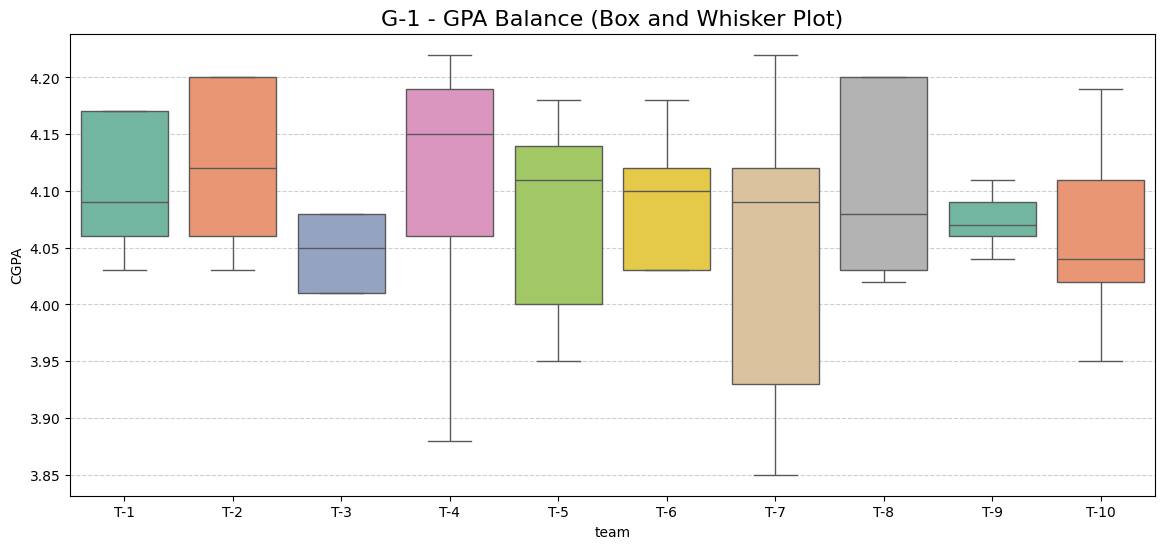

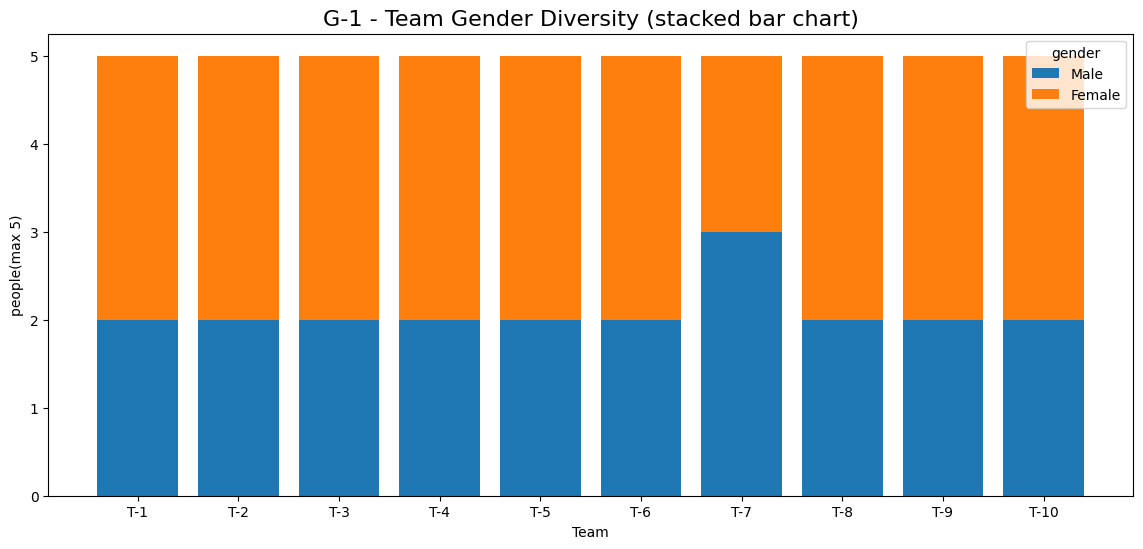

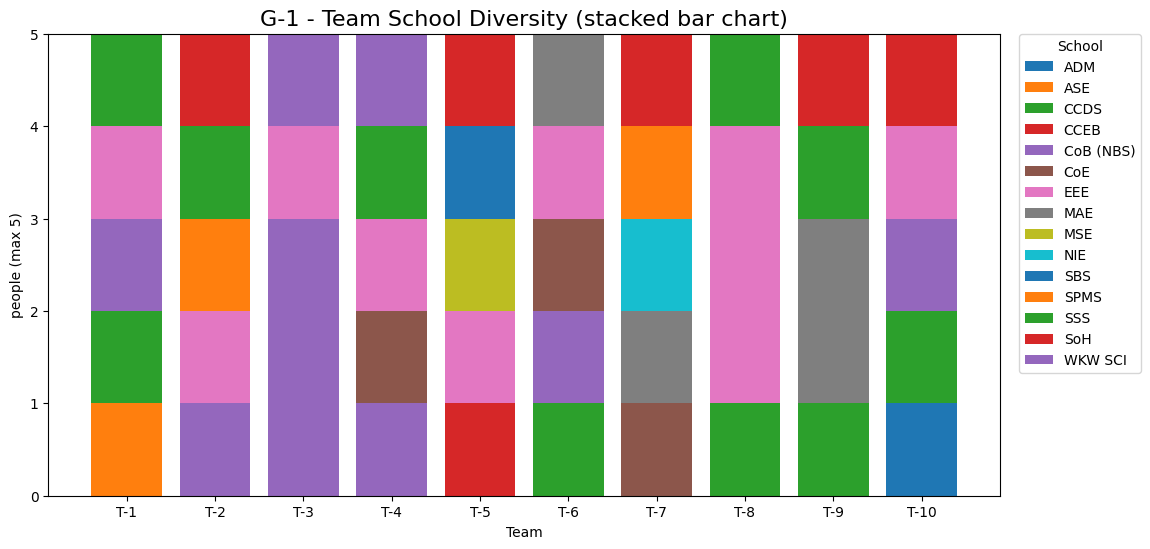

In [25]:
def main():
    
    # 1. load data
    banner("Load CSV File")
    students_by_class: dict[
        str, list[Student]
        ] | None = load_csv(INPUT_FILE)
    
    if students_by_class is None:
        print("Error: File not loaded properly")
        return

    # 2. Grouping and Optimizing
    grouped_students_sorted: list[Student]
    diversity_reports: list[dict[str, int]]

    banner("Run Full Grouping Process")
    grouped_students_sorted, diversity_reports = run_full_grouping_process(
        students_by_class
    )

    if len(grouped_students_sorted) == 0:
        print("Error: No grouped students")

    if len(diversity_reports) == 0:
        print("Error: No grouped students")
        
    # 3. Write Out
    banner("Write out to new CSV file")
    write_results_to_csv(grouped_students_sorted, OUTPUT_FILE)

    # 4. Evaluation
    banner("Evaluation")
    display_evaluation(diversity_reports)

    # 5. Visualization
    tutorial_group = "G-1" # Select the first class as representative
    banner(f"Generate Visual Charts for the Class '{tutorial_group}'")
    
    visualize_results(grouped_students_sorted, tutorial_group)


if __name__ == "__main__":
    main()